In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy.matlib
%matplotlib inline
from numpy.linalg import norm

In [212]:
filepath = '../ICRM_2_A/Batch-2-AF/myfiles/icrmMi/'
filepath = filepath.replace('/','\\')
# !dir $filepath

In [213]:
data = pd.read_csv(filepath+'icrmMi2.rmg', header=1).iloc[:,[0,5,6,9,10,11,12,14,15,16,17]]
data = data[data.iloc[:, 0]=='NRM']
data.columns=['','z','dz','x','dx','y','dy','dec','inc','M','CSD']
data.head()

,,z,dz,x,dx,y,dy,dec,inc,M,CSD
2,NRM,0.000121,0.000017,0.00288,0.000165,0.001528,0.000108,27.943774,2.124903,0.003263,2.937828


# Circular Standard Deviation (CSD) calculation
(based on Butler Chap.6, p.105-108, and Tauxe 11.2.1)

Given $N$ measured samples, we want to estimate the error in the mean direction. 
The first assumption is that the directions sampled from a Fisher distribution with precision parameter $\kappa$ approximated as: 

$ \kappa \approx k = (N-1)/(N-R)$

where $R$ is the norm of the vector composed of the sum of all samples in each component. So as $R$ goes to $N$, the precision increases. The approximated CSD is: 

 $S_{aprx} = 81/\sqrt k$

A rigorous definition is just the square root of the variance of the angles between the sampled directions and the mean direction: 

$S = \sqrt(\Sigma(\Delta_i^2)/(N-1))$

And an angle between two vectors $\vec{A}$ and $\vec{B}$ is: 

$\Delta = cos^{-1}(\frac{\vec{A}\cdot \vec{B}}{|A||B|})$

Either way in order to calculate CSD we need the original measurements in all components, but we don't have them. 
We do have the mean and standard deviation in each direction, and we can simulate $N=4$ samples to calculate CSD in both ways. 
Here we need to assume some distribution of the measurements in each component. We chose normal distribution as a basic assumption because we measure a natural quantity (Cartesian coordinates). 

In [203]:
def cal_CSD(N=4, plotflag=False, verbose=True):
  r = data[['x','y','z']].values 
  dr= data[['dx','dy','dz']].values

  # simulate N samples: 
  full_r = (np.random.randn(N,3)*dr+r);
  full_r = full_r/np.matlib.repmat(norm(full_r,axis=1),3,1).T

  R_vec = full_r.sum(axis=0)
  R = np.linalg.norm(R_vec)
  k = (N-1)/(N-R)

  # estimation for S: 
  S_aprx = 81/np.sqrt(k);
  if verbose:
    print('Approximated CSD: {:2.5}'.format(S_aprx))

  # rigorous calculation of S: 
  # calculate Delta for each sampled direction, which is the angular deviation from the mean:
  ang_dev = np.degrees(np.arccos(np.dot(full_r,r.T).T/(norm(full_r,axis=1)*norm(r))).T);
  S = np.sqrt(sum(ang_dev**2)/(N-1))
  if verbose:
    print('Calculated CSD: {:2.5}'.format(S[0]))

  if plotflag:
    plt.hist(ang_dev, bins=1000)
    plt.xlabel('Deviation from the mean direction');

    theta_vec=np.arange(0.001,np.pi/20,0.001)
    print('k = {}'.format(k))
    k = 700
    Fisher1 = k/(2*np.sinh(k))*np.exp(k*np.cos(theta_vec))*np.sin(theta_vec)
    k = 500
    Fisher2 = k/(2*np.sinh(k))*np.exp(k*np.cos(theta_vec))*np.sin(theta_vec)
    k = 100
    Fisher3 = k/(2*np.sinh(k))*np.exp(k*np.cos(theta_vec))*np.sin(theta_vec)

    h1,=plt.plot(np.degrees(theta_vec),Fisher1)
    h2,=plt.plot(np.degrees(theta_vec),Fisher2)
    h3,=plt.plot(np.degrees(theta_vec),Fisher3)
    plt.legend([h1,h2,h3],['k = 700','k = 500','k = 100']);

  return (S_aprx, S[0])

cal_CSD(N=4);

Approximated CSD: 2.0859
Calculated CSD: 2.2889


Both are in the same order of magnitude, but vary greatly each time we repeat this Monte-Carlo experiment. We can evaluate the precision of these results if we repeat it many times (Bootstrap). 
Furthermore, we can simulate many more samples and than calculate the CSD: 

In [204]:
cal_CSD(N=10)
cal_CSD(N=100)
cal_CSD(N=1000);

Approximated CSD: 2.4851
Calculated CSD: 2.5055
Approximated CSD: 1.9012
Calculated CSD: 1.9021
Approximated CSD: 1.955
Calculated CSD: 1.9563


Seems the approximated getting close to the calculated ones for large $N$. Now lets see if it fits the given CSD?

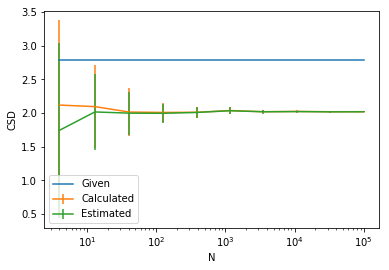

In [205]:
Ns = np.logspace(0.65, 5, num=10, dtype=int)
nBS = 50
S = np.empty([Ns.shape[0],nBS])
S_aprx = np.empty_like(S)
for i, N in enumerate(Ns):
  for j in range(nBS):
    S_aprx[i,j], S[i,j] = cal_CSD(N, verbose=False); 
plt.semilogx(Ns, np.ones_like(Ns)*data.CSD.values)
plt.errorbar(Ns, np.median(S,axis=1), yerr=np.diff(np.quantile(S,[.25,.75],axis=1),axis=0).T)
plt.errorbar(Ns, np.median(S_aprx,axis=1), yerr=np.diff(np.quantile(S_aprx,[.25,.75],axis=1),axis=0).T)
# plt.semilogx(Ns, np.median(S_aprx,axis=1))

plt.xlabel('N')
plt.ylabel('CSD')
plt.legend(['Given','Calculated','Estimated']);

So the given CSD is with agreement with the interqurtile of the $N=4$, but not for higher $N$, where the confidence is greater. 

If we plot the histogram of the deviations from the mean, for large $N$, we reconstruct the PDF of the directions about the mean: 

Approximated CSD: 2.0323
Calculated CSD: 2.034
k = 1588.5436921511316


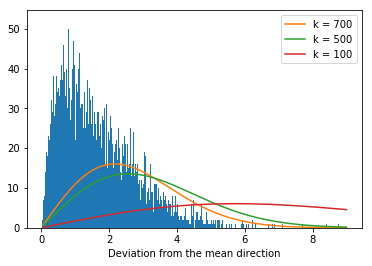

In [206]:
cal_CSD(N=10000, plotflag=True);

To me it looks like the Fisher Distribution, but I could not reconstruct it with the expected $k$ because it goes like exp(k) and here k is about 1000. But for smaller values of k it seems like it getting closer to the experimental PDF that we got, when we assumed x,y,z are normaly distributed! 


# Calculation of Errors of Angles
The transformations from Cartesian coordinates to (Magnitude, declination, inclination) are: 

$Mag = \sqrt(x^2+y^2+z^2)$

$dec = arctan(y/x)$

$inc = arcsin(z/Mag)$

In the literature the error in the inclination is taken as the CSD, $S$, and the error in the declination is: 

$sin(\Delta D) = \frac{sin(S)}{cos(inc)}$

We take different approach and try to evaluate the error by bootsrap. Assuming x,y,z, are normally distributed with the measured mean and the reported std, we simulate $N$ measurements, and applying the transformations. We then evaluate the error as the standard deviation of the distributions: 

Magnitude=0.000548+/-2.5e-05
Deviation between measured and simulated: 0.000, relative: 0.001
Reported value: 0.000548

Inclination=4.25+/-0.398
Deviation between measured and simulated: 0.006, relative: 0.001
Reported value: 4.24+/-2.8 (CSD)
Calculated CSD: 2.02

Declination=31.0+/-1.97
Deviation between measured and simulated: 0.043, relative: 0.001
Reported value: 30.9+/-0.0489 (Delta D formula)
Calculated Delta D (formula): 0.0354


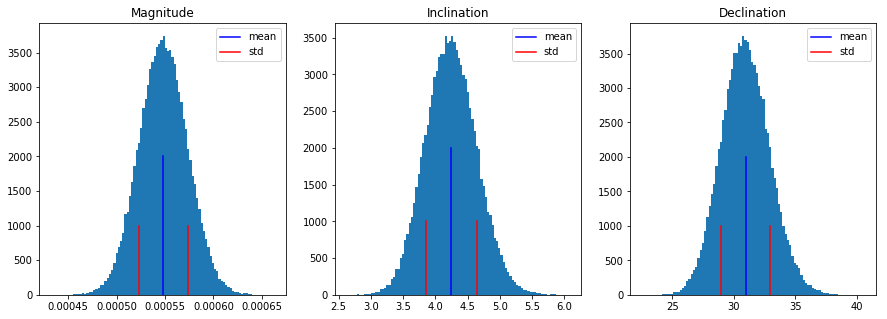

In [207]:
N=100_000
r = data[['x','y','z']].values
dr= data[['dx','dy','dz']].values
  # simulate N samples: 
R = (np.random.randn(N,3)*dr+r);
X = R[:,0]; Y = R[:,1]; Z = R[:,2]

def cart2mag_sph(X,Y,Z):
    MAG = np.sqrt(X**2 + Y**2 + Z**2)
    DEC = np.degrees(np.arctan2(Y,X))
    INC = np.degrees(np.arcsin(Z/MAG))
    return (MAG,DEC,INC)

MAG,DEC,INC=cart2mag_sph(X,Y,Z)
me_mag,me_dec,me_inc=cart2mag_sph(data.x.values,data.y.values,data.z.values)

# full_r = full_r/np.matlib.repmat(np.linalg.norm(full_r,axis=1),3,1).T
def hist_with_measures(DS, measured_value, measure):
    plt.hist(DS, bins=100)
    m=np.mean(DS)
    s=np.std(DS)
    h1,=plt.plot(np.array([1,1])*m,[0,len(DS)/50],'b')
    h2,=plt.plot(np.array([1,1])*(m+s),[0,len(DS)/100],'r')
    plt.plot(np.array([1,1])*(m-s),[0,len(DS)/100],'r')
    plt.legend([h1,h2],['mean','std'])
    plt.title(measure)
    print('{}={:2.3}+/-{:2.3}'.format(measure,m,s))
    print('Deviation between measured and simulated: {:2.3f}, relative: {:2.3f}'
          .format(np.abs(measured_value[0] - m), np.abs(measured_value[0]/m-1)))
    
        
fig = plt.figure(figsize=(15,5))
plt.subplot(131); hist_with_measures(MAG, me_mag, 'Magnitude');
print('Reported value: {:2.3}'.format(data.M.values[0]))
print('')

plt.subplot(132); hist_with_measures(INC, me_inc, 'Inclination');
print('Reported value: {:2.3}+/-{:2.3} (CSD)'.format(data.inc.values[0],data.CSD.values[0]))
C1,C = cal_CSD(N, verbose=False)
print('Calculated CSD: {:2.3}'.format(C))
print('')


plt.subplot(133); hist_with_measures(DEC, me_dec, 'Declination');
print('Reported value: {:2.3}+/-{:2.3} (Delta D formula)'.
      format(data.dec.values[0], np.arcsin(np.sin(np.radians(data.CSD.values))/np.cos(np.radians(data.inc.values)))[0]))
print('Calculated Delta D (formula): {:2.3}'.
      format(np.arcsin(np.sin(np.radians(C))/np.cos(np.radians(data.inc.values)))[0]))




# Angle between expacted (Magnetic field north) and measured directions

theta=4.75+/-0.935
Deviation between measured and simulated: 0.413, relative: 0.087


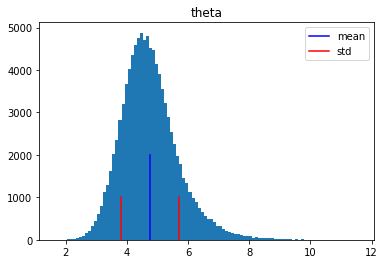

In [217]:
def ang_bet(R1,R2):
    '''angle between two vectors R1 and R2
    R2 may be a matrix'''
    return np.degrees(np.arccos((R1*R2).sum(axis=1)/(norm(R1,axis=1)*norm(R2,axis=1))))

R = (np.random.randn(N,3)*dr+r);
# b=np.array([[80.17,53.50,-5.33]])
# db=np.array([[5.44,3.38,5.96]])
b=np.array([[866  ,  500  ,  0]])
db=np.array([[7.6245 ,   3.2512  ,  9.4196]])
B = (np.random.randn(N,3)*db+b);
THETA=ang_bet(B,R)
theta=ang_bet(b,r)
hist_with_measures(THETA, theta, 'theta')

In [178]:
print((THETA).shape)
print(R1.shape,R2.shape)
np.degrees(np.arccos((R1*R2).sum(axis=1)/(norm(R1)*norm(R2,axis=1)))).shape

(100000,)
(5, 3) (5, 3)


(5,)

[[4.68872949e-04 2.80826741e-04 4.05239223e-05]]
1.6311245720936567


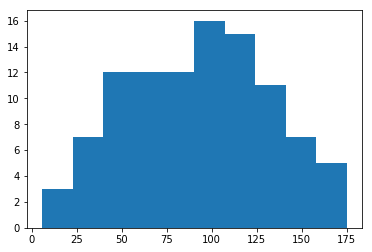

In [218]:
A=np.random.rand(100,1)*2-1
plt.hist(np.degrees(np.arccos(A)))
print(r)
print(min(THETA))

In [75]:
ang_bet(B,r)

array([89.8352768 , 89.8446425 , 89.819002  , ..., 89.82110541,
       89.81882872, 89.81697143])